In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
# ========== Load Dataset ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num,
        rows * cols))
    return data.astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

In [3]:
# TODO: Complete all the functions, you may change the structures
# ========= 2. Utils ==========
def shuffle_numpy(X, y):
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

def split_train_val(X, y, val_ratio=0.2):
    split_idx = int(len(X) * (1 - val_ratio))
    return X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:]

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def accuracy(Y_pred, Y_true):
    return np.mean(np.argmax(Y_pred, axis=1) == np.argmax(Y_true, axis=1))


In [4]:
# ========= 3. Model ==========
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim, weight_decay=0.0):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.lambda_ = weight_decay
        
    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
    
    def compute_loss(self, Y_pred, Y_true):
        # TODO: Weight Decay (L2 Regularization)
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / Y_true.shape[0]
        reg_loss = 0.5 * self.lambda_ * (np.sum(self.W1**2) + np.sum(self.W2**2))
        return loss + reg_loss
    
    def backward(self, X, Y_true, Y_pred, lr=0.1):
        m = Y_true.shape[0]
        dz2 = (Y_pred - Y_true) / m
        dW2 = self.a1.T @ dz2 + self.lambda_ * self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.relu_deriv(self.z1)
        dW1 = X.T @ dz1 + self.lambda_ * self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

In [5]:
# ========= 4. Train Function ==========
def train(model, X_train, y_train, X_val, y_val, lr=0.1, epochs=100, use_early_stopping=False, patience=5):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_loss = np.inf
    patience_count = 0
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            # TODO: complete this part
            Y_pred = model.forward(X_train)
            loss = model.compute_loss(Y_pred, y_train)
            model.backward(X_train, y_train, Y_pred, lr)

            Y_val_pred = model.forward(X_val)
            val_loss = model.compute_loss(Y_val_pred, y_val)

            train_losses.append(loss)
            val_losses.append(val_loss)
            train_accs.append(accuracy(Y_pred, y_train))
            val_accs.append(accuracy(Y_val_pred, y_val))
            
            pbar.set_postfix(epoch=epoch, loss=loss, val_loss=val_loss)
            pbar.update(1)
            # TODO: implement your early stopping strategy here
            if use_early_stopping:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_count = 0
                    else:
                        patience_count += 1
                    if patience_count >= patience:
                        print("Early stopping triggered.")
                        break
        print(f"Train accuracy: {accuracy(Y_pred, y_train)}, Val accuracy: {accuracy(Y_val_pred, y_val)}")

    return train_losses, val_losses, train_accs, val_accs

In [6]:
# ========= 5. Plotting ==========
def plot_curves(train_losses, val_losses, train_accs, val_accs, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve - " + title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Accuracy Curve - " + title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
# ========= 6. Main ==========
def main():
    X = load_images("data/train-images.idx3-ubyte____")
    y = load_labels("data/train-labels.idx1-ubyte____")
    X, y = shuffle_numpy(X, y)
    X_train, y_train, X_val, y_val = split_train_val(X, y)
    y_train_oh = one_hot(y_train, 10)
    y_val_oh = one_hot(y_val, 10)
    
    input_dim = X_train.shape[1]
    hidden_dim = 128
    output_dim = 10
    
    # === OPTION 1: Early Stopping ===
    model_early = MLP(input_dim, hidden_dim, output_dim, weight_decay=0.0)
    t1, v1, a1, a2 = train(model_early, X_train, y_train_oh, X_val, y_val_oh, use_early_stopping=True, patience=5)
    plot_curves(t1, v1, a1, a2, title="Early Stopping")
    
    # === OPTION 2: Weight Decay ===
    lambdas = [0.001, 0.01, 0.1]
    for lambda_val in lambdas:
        model_wd = MLP(input_dim, hidden_dim, output_dim, weight_decay=lambda_val)
        t2, v2, a3, a4 = train(
            model_wd, X_train, y_train_oh,
            X_val, y_val_oh, lr=0.1, epochs=100,
            use_early_stopping=False
        )
        plot_curves(t2, v2, a3, a4, title=f"Weight Decay (λ={lambda_val})")

100%|██████████| 100/100 [00:37<00:00,  2.69it/s, epoch=99, loss=0.936, val_loss=0.929]

Train accuracy: 0.7928958333333334, Val accuracy: 0.7900833333333334


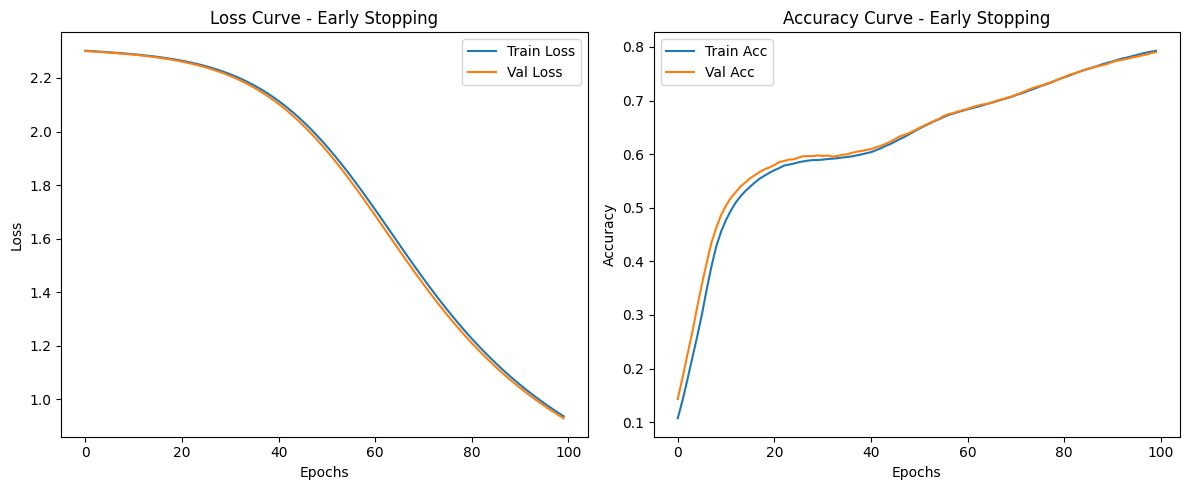

100%|██████████| 100/100 [00:33<00:00,  2.95it/s, epoch=99, loss=0.965, val_loss=0.956]

Train accuracy: 0.7867708333333333, Val accuracy: 0.7856666666666666


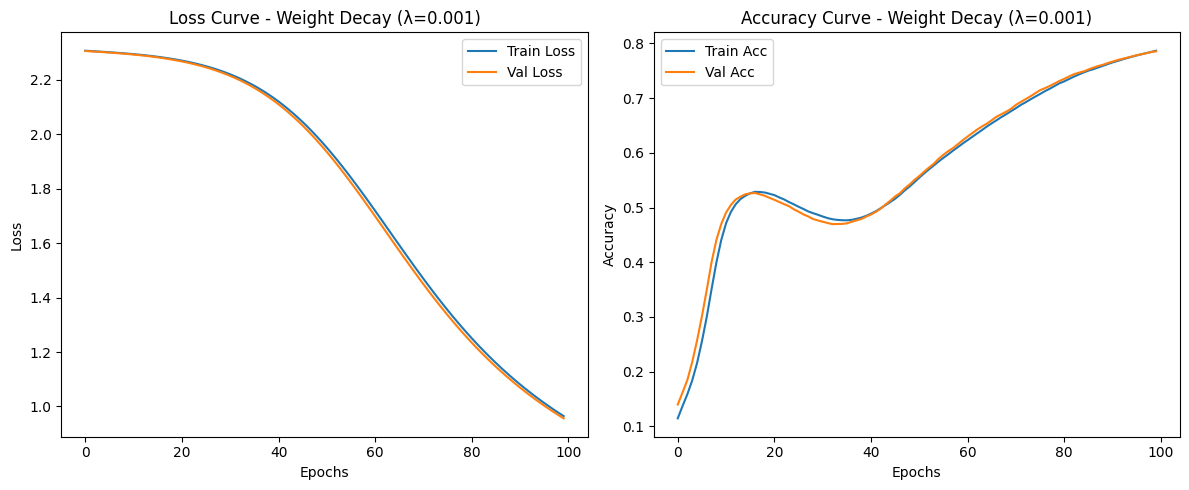

100%|██████████| 100/100 [00:36<00:00,  2.72it/s, epoch=99, loss=1.09, val_loss=1.08]

Train accuracy: 0.775625, Val accuracy: 0.77675


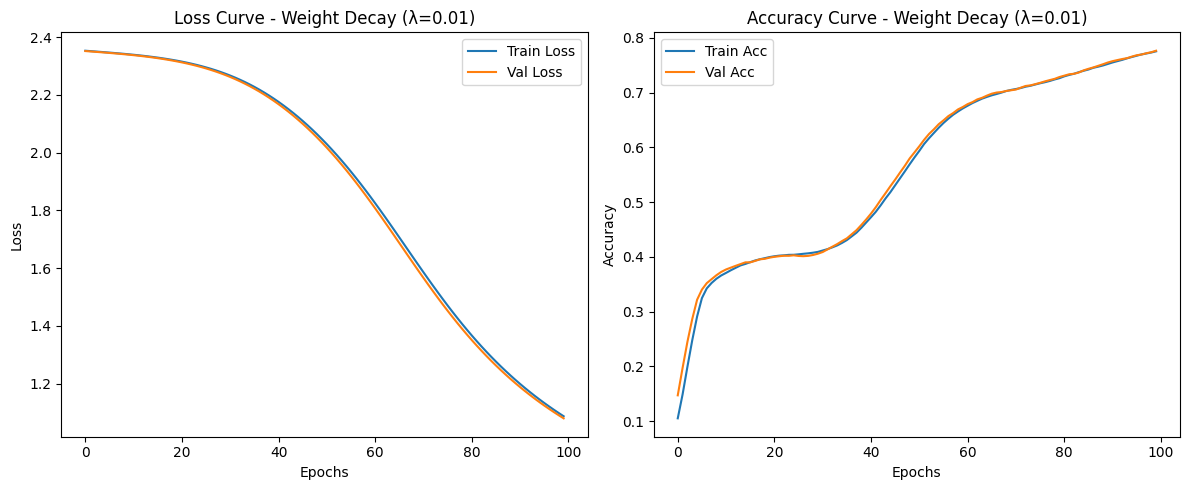

100%|██████████| 100/100 [00:31<00:00,  3.17it/s, epoch=99, loss=1.79, val_loss=1.78]

Train accuracy: 0.6725625, Val accuracy: 0.6741666666666667


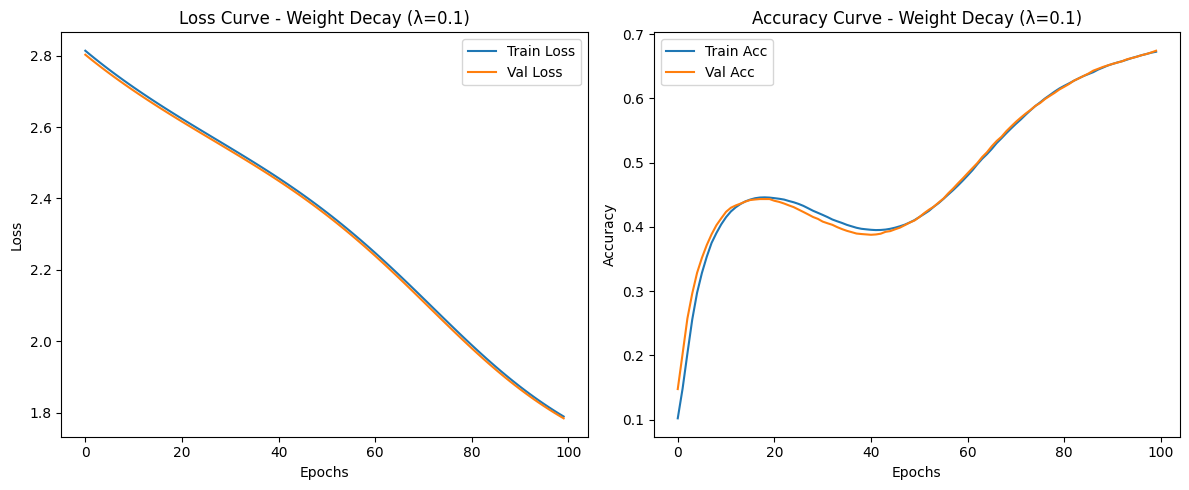

In [8]:
main()